In [1]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 113597 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Acoustic_Localization/keras/data/data_19_1") 


# 查看文件目录，是否包含所需的文件
!ls

drive  qd_LOS_32_berlin_20k.mat  qd_NLOS_32_berlin_20k.mat  v_LOS_32_20k.mat


In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as KK
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

Using TensorFlow backend.


In [2]:
#loading data
DDataFile = './data/data_Emre/v_LOS_32_20k.mat'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff = DData['h_coeff']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 2000
M = 32
h_coeff = h_coeff[:,:N]
loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M * M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
#     hH = h.H
    K = h * hH
    B = D * K * DH
    F[i] =B.flatten().A
F = np.asarray(F)
print(F.shape)
print(type(F))


h_coeff shape (32, 2000)
loc shape (2000, 2)
(2000, 1024)
<class 'numpy.ndarray'>


In [6]:

a = [3,4]
LA.norm(a, 2)
a

[3, 4]

In [4]:

# real_D = np.real(F)
# img_D = np.imag(F)

ft = np.absolute(F) # get the absolute of the F data

print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, l = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = ft[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = ft[train_length:, :]
location_test = loc[train_length:,:]

 
print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print('location_train shape:', location_train.shape)
print('location_test shape:', location_test.shape)

ft shape (2000, 1024) <class 'numpy.ndarray'>
(2000, 1024) (2000, 2)
2000 1600 (1600, 1024) (1600, 2)
impulses_train shape: (1600, 1024)
impulses_test shape: (400, 1024)
location_train shape: (1600, 2)
location_test shape: (400, 2)


In [6]:
#Build the model
model = keras.Sequential()

#model.add(keras.layers.normalization.BatchNormalization())

model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(Dense(512, activation = 'relu')) 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [9]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.RMSprop() #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)
print(type(impulses_train))

(8000, 1024) (8000, 2)
<class 'numpy.ndarray'>


In [11]:
#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 1000, # 50 -> 52138; 20->52088
                    epochs = 10,
                    verbose = 1,
                    validation_split = 0.1 #0.2
#                     validation_data=(impulses_test,location_test)
                   )


(8000, 1024) (8000, 2)
(2000, 1024) (2000, 2)
Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 1s 145us/step - loss: 52696.1864 - val_loss: 52095.1484
Epoch 2/10
7200/7200 [==============================] - 1s 146us/step - loss: 52673.3874 - val_loss: 52082.7500
Epoch 3/10
7200/7200 [==============================] - 1s 138us/step - loss: 52674.8391 - val_loss: 52094.0195
Epoch 4/10
7200/7200 [==============================] - 1s 147us/step - loss: 52675.6791 - val_loss: 52080.9258
Epoch 5/10
7200/7200 [==============================] - 1s 143us/step - loss: 52667.9212 - val_loss: 52102.4531
Epoch 6/10
7200/7200 [==============================] - 1s 145us/step - loss: 52667.8056 - val_loss: 52103.0312
Epoch 7/10
7200/7200 [==============================] - 1s 139us/step - loss: 52668.6202 - val_loss: 52107.9453
Epoch 8/10
7200/7200 [==============================] - 1s 143us/step - loss: 52670.6234 - val_loss: 52114.1562
Epoch 9/10


In [30]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

(400, 2)
(400, 2)
400/400 [==============================] - 0s 193us/step
Test loss & mean_absolute_error:  52729.5428125


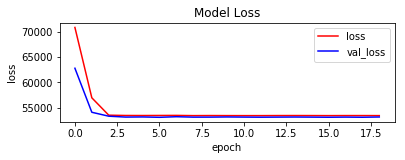

In [20]:
#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()



# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.set_title('Location Scatter Plot')
# ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
# ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
# plt.legend()
# plt.show()

error distance is  298.53494978653436
max error distance is  551.2667058529189
min error distance is  18.105255221106894


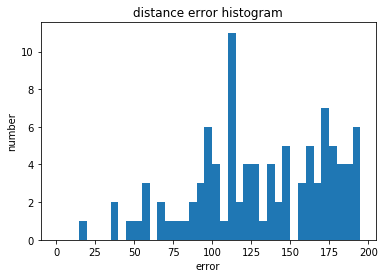

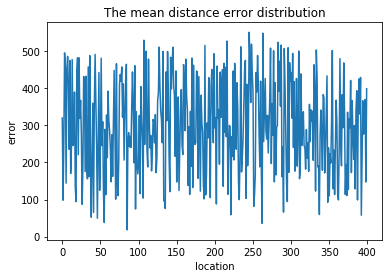

(400, 1)

In [21]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,200,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

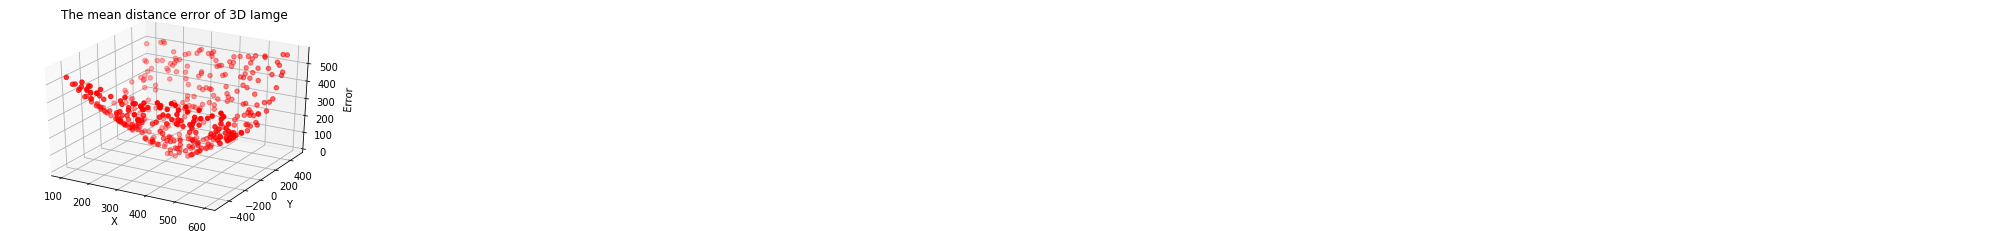

In [22]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

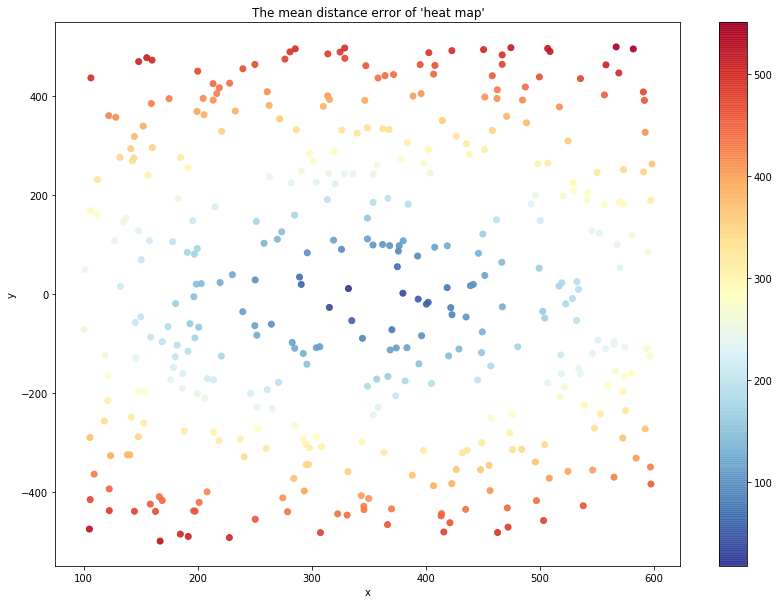

In [23]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")

the mean of error 169.561867
the max of error 256.628716
the max of error 57.756996


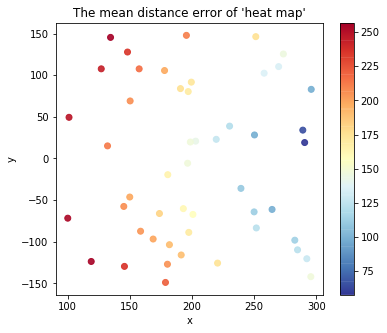

In [24]:
#plot small scale error map

err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.show()


Text(0.5, 1.0, 'distance error histogram')

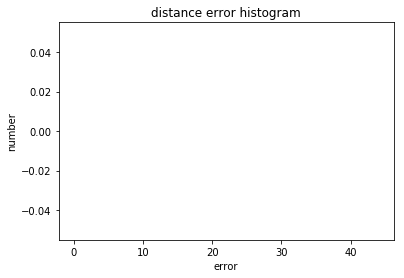

In [25]:

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(np.array(err_map_300['err']), bins =  range(0,45,1)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 